title of the project

## 1. Importing Necessary Modules & Loading the Data

 I start by importing any necessary modules, as shown. Following this, I will import our data (mnist): 

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.datasets import fetch_openml
from sklearn.multiclass import OneVsRestClassifier


mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
np.random.seed(42)

## 2. Exploratory Data Analysis (EDA)

I begin exploratory data analysis by examining the dataset type:

In [2]:
print(type(mnist))

<class 'sklearn.utils._bunch.Bunch'>


The code above shows that mnist is a dictionary-like object (Bunch), not a DataFrame. Therefore, we can list all keys in mnist using .keys()

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

For EDA, I will use only two of these keys: "data", "target". The key "data" contains an array where each row represents a sample and each column represents a feature. The key "target" contains an array with the labels.
 
The key "DESCR" provides the same information as mnist.DESCR. It contains a description of the dataset.

In [4]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

The following code shows that we have 70000 rows (samples) and 784 columns (features). Each sample is an image that was originally 2D with 28×28 pixel values, but it was later flattened into a 1D array with 784 values.

In [5]:
mnist["data"].shape

(70000, 784)

The following code indicates that we have 70000 labels, where each label is a single digit from 0 to 9, representing the correct digit for the corresponding image.

In [6]:
mnist["target"].shape

(70000,)

To confirm that images are stored correctly in mnist["data"] and mnist["target"], ensure proper reshaping (from 1D to 2D), and visually check image quality to see if the digits are clear and readable, I used the following code:

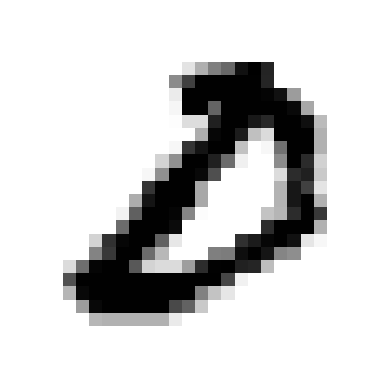

Label: 0


In [7]:
random_index = np.random.randint(0, 70000) # to select a random index every time we run the code
one_sample=mnist["data"][random_index]
one_sample_image = one_sample.reshape(28, 28)
plt.imshow(one_sample_image, cmap="binary")
plt.axis("off")
plt.show()

one_sample_label = mnist["target"][random_index]
print(f"Label: {one_sample_label}")

Then, I split my data into `X` and `y`:

In [8]:
X= mnist["data"]
y= mnist["target"].astype(np.uint8)

To check if there is any missing data:

In [9]:
print(f"Missing values in X: {np.isnan(X).sum()}") 
print(f"Missing values in y: {np.isnan(y).sum()}") 

Missing values in X: 0
Missing values in y: 0


The dataset is clean and do not have any missing value.

Finally, I examined the class distribution to check how many samples exist for each digit (0–9). 

The dataset is slightly imbalanced, with some digits appearing more frequently than others. For example, the digit 5 appears 6313 times, while the digit 1 appears 7877 times. Ideally, all ten classes should have a similar distribution to ensure the model does not become biased toward more frequent digits.

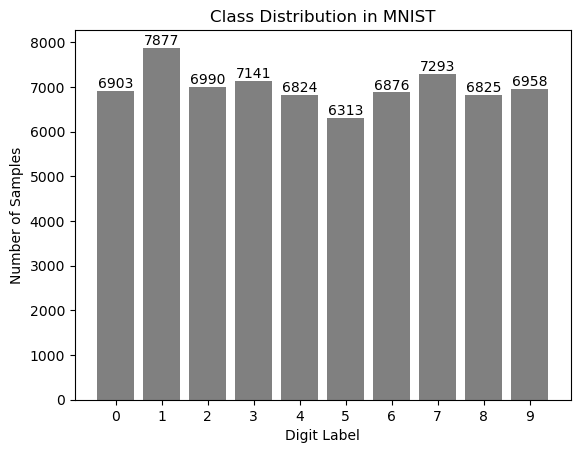

In [10]:
# to find all unique digits (0–9) and counts how many times each appears
unique, counts = np.unique(mnist["target"], return_counts=True) 
plt.bar(unique, counts, color="grey")
plt.xlabel("Digit Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in MNIST")
plt.xticks(range(10))  # Ensure labels 0-9 are visible
# to add the count values on top of each bar in a bar chart.
for i, count in zip(unique, counts):
    plt.text(i, count + 70, str(count), ha="center", fontsize=10, color="black")

plt.show()

The imbalance is small and unlikely to impact performance. Therefore, I will train the models without balancing first. If bias appears in the predictions, I will consider downsampling.

## 3. Preparing the data 

Since the MNIST dataset has no missing data, no cleaning is needed. However, the pixel values in X range from 0 to 255, so it is best to normalize X before splitting the data. This is particularly useful for models that are sensitive to feature scaling, ensuring that the large pixel values (255) do not dominate the results.

In [11]:
X = X / 255.0

I split the dataset into three subsets: 50,000 instances for training, 10,000 for validation, and 10,000 for testing. First, I will train the models using the training set. Then, I will use the validation set to evaluate their performance and select the best model. Finally, I will use the test set to assess the final model’s performance on unseen data.

In [12]:
# First Split (Train+Val & Test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=10000, random_state=42)
# Second Split (Train & Validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000, random_state=42)

## 4. Building and Comparing Classification Models

In this section, I will train multiple models to classify the MNIST dataset. This is a multiclass classification problem, as we need to classify images into ten classes (digits 0–9).

According to Géron (2019), multiclass classification can be handled either by models that natively support multiple classes or by applying One-Versus-One (OvO) or One-Versus-Rest (OvR) strategies to extend binary classifiers (p. 100).

In the next steps, I will train and compare different models to determine the best-performing one for this task.

¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨

4.1. For my first model, I choose Logistic Regression, which is originally a binary classifier. Since MNIST is a multiclass classification problem (digits 0-9), I handle it using the One-Versus-Rest (OvR) strategy. This allows Logistic Regression to train one binary classifier per class, treating each digit as 'this class vs. all others.

In [13]:
# Initialize Logistic Regression with One-Versus-Rest
log_reg_ovr = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
log_reg_ovr.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000,
                                                 random_state=42))

In [14]:
log_reg_ovr_pred = log_reg_ovr.predict(X_val)
log_reg_ovr_accuracy = accuracy_score(y_val, log_reg_ovr_pred )
print("The accuracy score of Logistic Regression model (OVR) is:", log_reg_ovr_accuracy)

The accuracy score of Logistic Regression model (OVR) is: 0.9164


4.2. For my second model, I choose Linear SVC, a classification model based on Support Vector Machines (SVMs). I selected Linear SVC because it is faster than a standard SVM classifier, making it more efficient for large datasets like MNIST. Linear SVC is also designed for binary classification. butHowever, it can handle multiclass problems using One-Versus-Rest (OvR). OvR is the default strategy for LinearSVC when applied to multiclass classification problems.



In [15]:
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
svm_clf.fit(X_train, y_train)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(max_iter=100, random_state=42, tol=20)

In [16]:
svm_clf_pred = svm_clf.predict(X_val)
svm_clf_accuracy = accuracy_score(y_val, svm_clf_pred)
print("The accuracy score of Linear SVC is:", svm_clf_accuracy)

The accuracy score of Linear SVC is: 0.8753


4.3. For the third model, I use k-Nearest Neighbors (k-NN), as suggested in Hands-On ML (Exercise 1, Chapter 3). k-NN classifies samples based on their closest neighbors without training a model. 


In [17]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [18]:
knn_clf_pred = knn_clf.predict(X_val)
knn_clf_accuracy = accuracy_score(y_val, knn_clf_pred)
print("The accuracy score of K Nearest Neighbors (k-NN) model is:", knn_clf_accuracy)

The accuracy score of K Nearest Neighbors (k-NN) model is: 0.9702


4.4. For the fourth model, I chose Random Forest, an ensemble learning method that combines multiple decision trees to improve accuracy and reduce overfitting. It is well-suited for multiclass classification and can handle large datasets efficiently.

In [19]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [20]:
random_forest_clf_pred = random_forest_clf.predict(X_val)
random_forest_clf_accuracy = accuracy_score(y_val, random_forest_clf_pred)
print("The accuracy score of Random Forest Classifier is:", random_forest_clf_accuracy)

The accuracy score of Random Forest Classifier is: 0.9692


4.5. The last model I chose was Extra Trees, an ensemble method similar to Random Forest but with more randomness in split selection. This makes training faster and can improve generalization for large datasets.

In [21]:
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
extra_trees_clf.fit(X_train, y_train)

ExtraTreesClassifier(random_state=42)

In [22]:
extra_trees_clf_pred = extra_trees_clf.predict(X_val)
extra_trees_clf_accuracy = accuracy_score(y_val, extra_trees_clf_pred)
print("The accuracy score of Extra Tree Classifier is:", extra_trees_clf_accuracy)

The accuracy score of Extra Tree Classifier is: 0.9715


## 5. Hyperparameter tuning

In this step, I compared the accuracy scores of the five models. Two models, k-NN and Extra Trees, achieved the highest scores, so I decided to fine-tune their hyperparameters.
First, I used GridSearchCV for both models, but Extra Trees was very slow. To improve efficiency, I switched to RandomizedSearchCV for Extra Trees.

5.1 k-NN model: GridSearchCV

In [23]:
# Define hyperparameter grid
param_grid_knn = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"]
}

# Perform Grid Search
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring="accuracy", n_jobs=-1)
grid_search_knn.fit(X_train, y_train)


# Print best parameters
print("Best k-NN Parameters:", grid_search_knn.best_params_)

Best k-NN Parameters: {'n_neighbors': 3, 'weights': 'distance'}


In [24]:
best_knn_clf = KNeighborsClassifier(n_neighbors=3, weights="distance")
best_knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [25]:
best_knn_clf_pred = best_knn_clf.predict(X_val)
best_knn_clf_accuracy = accuracy_score(y_val, best_knn_clf_pred)
print("The accuracy score of best k-NN model is:", best_knn_clf_accuracy)

The accuracy score of best k-NN model is: 0.9716


5.2. Extra tree model: RandomizedSearchCV

In [26]:
param_dist_et = {
    "n_estimators": [100, 200, 300], 
    "max_depth": [None, 10, 20],  
    "min_samples_split": [2, 5],  
    "min_samples_leaf": [1, 2]
}

# Perform Randomized Search with fewer iterations
random_search_et = RandomizedSearchCV(ExtraTreesClassifier(random_state=42), param_distributions=param_dist_et,  n_iter=10, cv=3,  scoring="accuracy", n_jobs=-1,  random_state=42, verbose=1)

random_search_et.fit(X_train, y_train)
print("Best Extra Trees Parameters:", random_search_et.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Extra Trees Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}


In [27]:
best_et_clf = ExtraTreesClassifier(
    n_estimators=300, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    max_depth=20,
    random_state=42  
)
best_et_clf.fit(X_train, y_train)



ExtraTreesClassifier(max_depth=20, n_estimators=300, random_state=42)

In [28]:
best_et_clf_pred = best_et_clf.predict(X_val)
best_et_clf_accuracy = accuracy_score(y_val, best_et_clf_pred)
print("The accuracy score of best k-NN model is:", best_et_clf_accuracy)

The accuracy score of best k-NN model is: 0.972


Next, I retrained the models using the best hyperparameters, which resulted in a slight increase in accuracy. I then compared the confusion matrices of the two optimized models and also analyzed their classification reports to evaluate their performance in more detail.

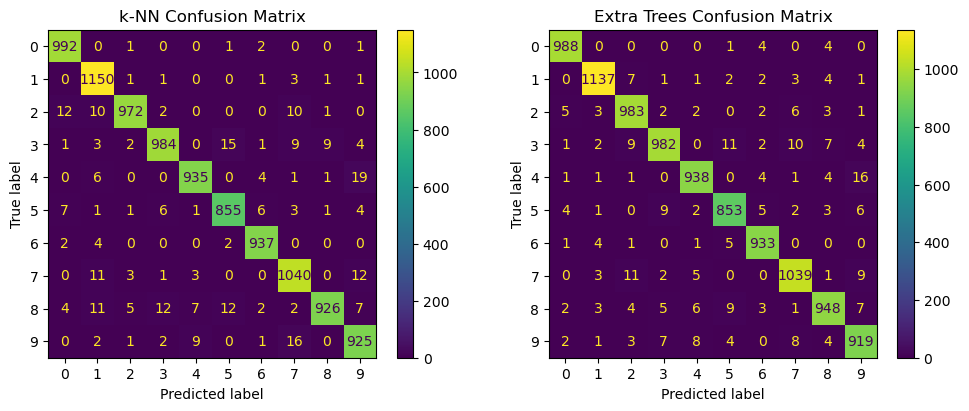

In [29]:
# Define digit labels for MNIST (0-9)
target_names_mnist = [str(i) for i in range(10)]

# Compute confusion matrices for both models
cm_knn = confusion_matrix(y_val, best_knn_clf.predict(X_val))
cm_et = confusion_matrix(y_val, best_et_clf.predict(X_val))

# Plot side-by-side confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout='constrained')
ConfusionMatrixDisplay(cm_knn, display_labels=target_names_mnist).plot(ax=axs[0])
ConfusionMatrixDisplay(cm_et, display_labels=target_names_mnist).plot(ax=axs[1])

# Remove grid for better readability
[ax.grid(False) for ax in axs]

# Add titles
axs[0].set_title("k-NN Confusion Matrix")
axs[1].set_title("Extra Trees Confusion Matrix")

plt.show()

In [30]:
best_et_clf_pred = best_et_clf.predict(X_val)
print(classification_report(y_val, best_et_clf_pred, target_names= target_names_mnist))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       997
           1       0.98      0.98      0.98      1158
           2       0.96      0.98      0.97      1007
           3       0.97      0.96      0.96      1028
           4       0.97      0.97      0.97       966
           5       0.96      0.96      0.96       885
           6       0.98      0.99      0.98       945
           7       0.97      0.97      0.97      1070
           8       0.97      0.96      0.96       988
           9       0.95      0.96      0.96       956

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [31]:
best_knn_clf_pred = best_knn_clf.predict(X_val)
print(classification_report(y_val, best_knn_clf_pred, target_names= target_names_mnist))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       997
           1       0.96      0.99      0.98      1158
           2       0.99      0.97      0.98      1007
           3       0.98      0.96      0.97      1028
           4       0.98      0.97      0.97       966
           5       0.97      0.97      0.97       885
           6       0.98      0.99      0.99       945
           7       0.96      0.97      0.97      1070
           8       0.99      0.94      0.96       988
           9       0.95      0.97      0.96       956

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



## 6. Ensemble Model

After tuning the hyperparameters, I created an ensemble model by combining the two best-performing models: k-NN and Extra Trees using a "Voting Classifier". The ensemble achieved a higher accuracy score than the individual models, making it the best model for this task.

I selected this ensemble as my final model and used it for testing on the unseen data

In [38]:
ensemble_clf = VotingClassifier(
    estimators=[
        ('knn', best_knn_clf), 
        ('extratrees', best_et_clf)
    ], 
    voting='soft'  # Weighted probability voting
)

ensemble_clf.fit(X_train, y_train)

# Evaluate on validation set
ensemble_clf_pred = ensemble_clf.predict(X_val)
ensemble_clf_accuracy = accuracy_score(y_val, ensemble_clf_pred)

print("Ensemble Accuracy:", ensemble_clf_accuracy)

Ensemble Accuracy: 0.9742


## 7. Evaluating the Best Model on the Test Set

To do this, I retrain the best model using both the training and validation data. Then, I make predictions on the test set (X_test). Finally, the model's performance is evaluated using the accuracy score, confusion matrix, and classification report.

In [33]:
# Now we retrain our model on the train + validation data. 
ensemble_clf_final = ensemble_clf.fit(X_train_val, y_train_val)
pred_test = ensemble_clf_final.predict(X_test)

In [34]:
# to evaluate the best model (Ensemble) on the test data:
ensemble_test_accuracy = accuracy_score(y_test, pred_test)
print("Final Test Accuracy (Ensemble):", ensemble_test_accuracy)

Final Test Accuracy (Ensemble): 0.9746


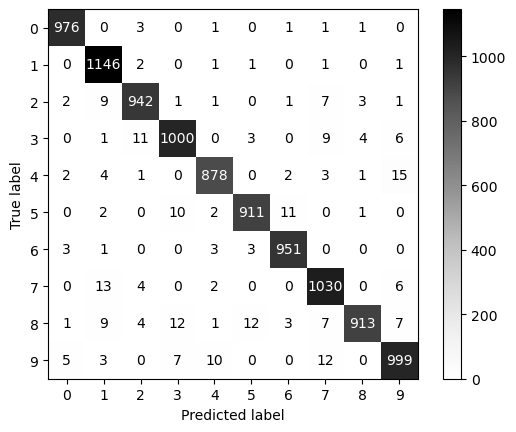

In [35]:
cm_final = confusion_matrix(y_test, pred_test)
ConfusionMatrixDisplay(cm_final, display_labels=[str(i) for i in range(10)]).plot(cmap="Grays")
plt.show()

By using the following code, I can print a breakdown of the most common misclassifications. This error analysis shows that my model performs well overall but struggles more with certain digits, particularly 8, 9, 3, and 4.

In [42]:
misclassified_counts = np.where(y_test != pred_test)[0]
print(f"Total misclassified samples: {len(misclassified_counts)}")

# Count misclassifications per true label
misclassifications_per_class = cm_final.sum(axis=1) - np.diag(cm_final)
for i in range(10):
    print(f"Digit {i} misclassified {misclassifications_per_class[i]} times.")

Total misclassified samples: 254
Digit 0 misclassified 7 times.
Digit 1 misclassified 6 times.
Digit 2 misclassified 25 times.
Digit 3 misclassified 34 times.
Digit 4 misclassified 28 times.
Digit 5 misclassified 26 times.
Digit 6 misclassified 10 times.
Digit 7 misclassified 25 times.
Digit 8 misclassified 56 times.
Digit 9 misclassified 37 times.


To better understand errors, I plot a few misclassified images along with their true and predicted labels.

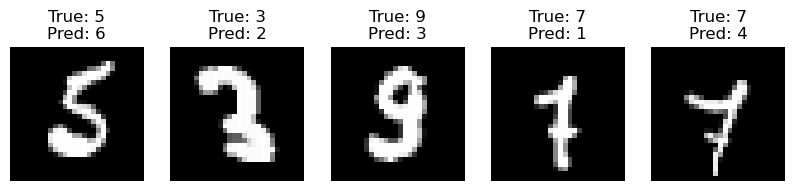

In [49]:
misclassified_indexes = np.where(y_test != pred_test)[0]
random_samples = random.sample(list(misclassified_indexes), 5)

# Plot the misclassified images
plt.figure(figsize=(10,5))
for i, idx in enumerate(random_samples):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[idx].reshape(28,28), cmap='gray')
    plt.axis('off')
    plt.title(f"True: {y_test[idx]}\nPred: {pred_test[idx]}")
plt.show()

In [36]:
target_names_mnist = [str(i) for i in range(10)]
print(classification_report(y_test, pred_test, target_names=target_names_mnist))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       983
           1       0.96      0.99      0.98      1152
           2       0.97      0.97      0.97       967
           3       0.97      0.97      0.97      1034
           4       0.98      0.97      0.97       906
           5       0.98      0.97      0.98       937
           6       0.98      0.99      0.99       961
           7       0.96      0.98      0.97      1055
           8       0.99      0.94      0.97       969
           9       0.97      0.96      0.96      1036

    accuracy                           0.97     10000
   macro avg       0.98      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



## 8. Saving the best model

Finally, I saved the best model for future use using joblib.dump. This allows me to reload the model later without retraining.

In [ ]:
import joblib
joblib.dump(ensemble_clf_final, "mnist_ensemble_final.pkl")

['mnist_ensemble_final.pkl']

In this report, I used machine learning to model and classify the MNIST dataset. I compared five different models: Logistic Regression, Linear SVC, k-NN, Random Forest, and Extra Trees  and evaluated their performance based on accuracy.

After identifying k-NN and Extra Trees as the best-performing models, I fine-tuned their hyperparameters and created an ensemble model. This ensemble achieved the highest accuracy (97.42%), demonstrating that combining these models improved classification.

An analysis of misclassifications revealed that certain digits, particularly 8 and 9, were more prone to being incorrectly classified. This may be due to their visual similarity to other digits. At the same time, digits 0, 6, and 8 performed best in terms of precision and F1-score, indicating strong model performance for these classes.

Although I initially selected the best models based on accuracy, I conducted a deeper analysis after hyperparameter optimization using confusion matrices and classification reports. This provided a more detailed view of how the models performed on individual digits and confirmed that the ensemble method offered a better balance between precision and recall.

In summary, the results show that the ensemble method improved accuracy and that the model generalizes well across the entire dataset